In [236]:
import datetime
import random

import graphviz
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.display import Image
from scipy.stats import randint
from sklearn import metrics, tree
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, f1_score, log_loss,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

In [237]:
df_nn = pd.read_csv("nn_data.csv")

print(df_nn.isna().sum())

# drop rows with nan
df_nn = df_nn.dropna().reset_index(drop=True)


Unnamed: 0                           0
PolicyholderOccupation             340
ClaimCause                         191
FirstPartyVehicleType               12
ConnectionBetweenParties             0
PolicyWasSubscribedOnInternet        0
NumberOfPoliciesOfPolicyholder       0
FpVehicleAgeMonths                   0
EasinessToStage                      0
ClaimWihoutIdentifiedThirdParty      0
ClaimAmount                          0
LossHour                            94
PolicyHolderAge                     36
NumberOfBodilyInjuries               0
FirstPartyLiability                  0
Fraud                                0
Days                                 0
PolicyHolderCount                    0
Accessories                        189
ActLiability                       189
Burglary                           189
Fire                               189
MaterialDamages                    189
MedicalCare                        189
NaturalCatastrophes                189
ReplacementVehicle       

In [238]:
# df_nn.groupby("Fraud")["Days"].value_counts(normalize=True)


In [239]:
# convert binary columns to ints
df_nn["PolicyWasSubscribedOnInternet"] = df_nn["PolicyWasSubscribedOnInternet"].astype("int64")
df_nn["ClaimWihoutIdentifiedThirdParty"] = df_nn["ClaimWihoutIdentifiedThirdParty"].astype("int64")

# these columns are already encoded
already_encoded = ["Accessories","ActLiability","Burglary","Fire","MaterialDamages","MedicalCare",
                   "NaturalCatastrophes","ReplacementVehicle","RiderClothes","Theft","ThirdParty",
                   "ThirdPartyMaterialDamages","Windscreen"]

# df_nn.drop("ConnectionBetweenParties", axis=1, inplace=True)
# df_nn.drop("PolicyholderOccupation", axis=1, inplace=True)

# find which columns are categorical and which are numerical
categorical_columns = []
numerical_columns = []
for col in df_nn.columns:
    if df_nn[col].dtype not in ['int64', "float64", "uint8"]:
        categorical_columns.append(col)
    else:
        # not binary data and not previously one-hot encoded
        if col not in ["PolicyWasSubscribedOnInternet", "ClaimWithoutIdentifiedThirdParty", "Fraud"] and col not in already_encoded and df_nn[col].dtype != "uint8":
            numerical_columns.append(col)
print(numerical_columns)
print(categorical_columns)

# one hot encode the categorical columns
df_nn = pd.get_dummies(df_nn, drop_first=True, columns=categorical_columns)

['Unnamed: 0', 'NumberOfPoliciesOfPolicyholder', 'FpVehicleAgeMonths', 'EasinessToStage', 'ClaimWihoutIdentifiedThirdParty', 'ClaimAmount', 'LossHour', 'PolicyHolderAge', 'NumberOfBodilyInjuries', 'FirstPartyLiability', 'Days', 'PolicyHolderCount']
['PolicyholderOccupation', 'ClaimCause', 'FirstPartyVehicleType', 'ConnectionBetweenParties']


In [240]:
# Splitting the dataset
x = df_nn.drop("Fraud", axis=1)
y = df_nn["Fraud"]

print(x.shape)
print(y.shape)

x_non_fraud = x[y==0]
y_non_fraud = y[y==0]
x_fraud = x[y==1]
y_fraud = y[y==1]
print("----------")
print(x_non_fraud.shape)
print(y_non_fraud.shape)
print(x_fraud.shape)
print(y_fraud.shape)

# split the non fraud data into train and other dataset
x_train, x_other, y_train, y_other = train_test_split(x_non_fraud, y_non_fraud, test_size=0.1, shuffle=True, random_state=300)

# concatenate the other dataset with the fraud cases
x_other = pd.concat((x_other, x_fraud), axis=0)
y_other = pd.concat((y_other, y_fraud), axis=0)
print("----------")
print(x_other.shape)
print(y_other.shape)
print("----------")
# split this into validation and test datasets
x_test, x_valid, y_test, y_valid = train_test_split(x_other, y_other, stratify=y_other, train_size=0.5, shuffle=True, random_state=380)

print(x_test[y_test==1].shape)
print(x_test[y_test==0].shape)
print(x_valid[y_valid==1].shape)
print(x_valid[y_valid==0].shape)
print("----------")

(10889, 61)
(10889,)
----------
(10781, 61)
(10781,)
(108, 61)
(108,)
----------
(1187, 61)
(1187,)
----------
(54, 61)
(539, 61)
(54, 61)
(540, 61)
----------


In [241]:
# Scaling the dataset
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x_train[numerical_columns] = min_max_scaler.fit_transform(x_train[numerical_columns])
x_valid[numerical_columns] = min_max_scaler.transform(x_valid[numerical_columns])
x_test[numerical_columns] = min_max_scaler.transform(x_test[numerical_columns])

In [242]:
# Encoder
encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(x_train.shape[1], )),
    tf.keras.layers.Dense(40, activation="elu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
])

# Decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(40, activation="relu"),
    tf.keras.layers.Dense(x_train.shape[1], activation="sigmoid")
])

# Autoencoder
model = tf.keras.Sequential([encoder, decoder])

model.build(x_train.shape)
encoder.summary()
decoder.summary()
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics="mse"
              )

history = model.fit(x_train, x_train, batch_size=256, epochs=300, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 40)                2480      
                                                                 
 dense_17 (Dense)            (None, 16)                656       
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
Total params: 3,272
Trainable params: 3,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (9702, 16)                144       
                                                                 
 dense_20 (Dense)            (

In [243]:
def predict_mse_histogram_validation(model, density=True):
    # predict on the validation data
    x_hat_valid = model.predict(x_valid)
    mse_valid = np.mean((x_valid - x_hat_valid)**2, axis = 1)

    # histgram of the MSE
    plt.hist(mse_valid[y_valid == 0], density=density, color='turquoise', alpha=0.8)
    plt.hist(mse_valid[y_valid == 1], density=density, color='orange', alpha=0.8)
    plt.legend(["non fraud", "fraud"])
    plt.xlabel("MSE")
    # plt.ylabel("count")
    plt.title("MSE histogram on validation data")
    plt.show()

19/19 [==============================] - 0s 793us/step


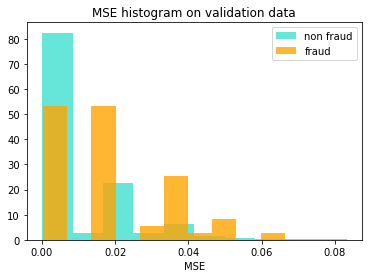

In [244]:
predict_mse_histogram_validation(model)

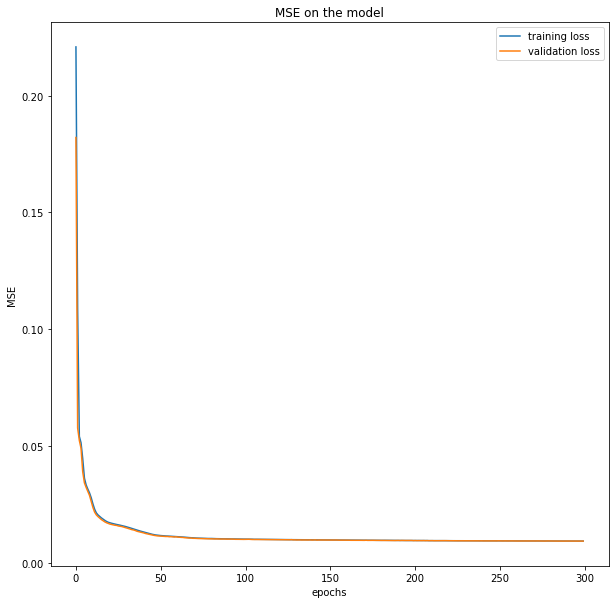

In [245]:
# Plot the training and validation losses
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["training loss", "validation loss"])
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.title("MSE on the model")
plt.show()

In [246]:
import keras_tuner as kt

# hyperparameter tuning
def build(hp):
    # number of hidden units per layer
    num_units_l1 = hp.Int('num_units_l1', min_value = 30, max_value=35)
    num_units_l2 = hp.Int('num_units_l2', min_value = 15, max_value=20)
    num_units_l3 = hp.Int('num_units_l3', min_value = 8, max_value=12)
    num_units_l4 = hp.Int('num_units_l4', min_value = 4, max_value=10)

    tf.keras.Sequential([
        tf.keras.layers.Input(shape=(x_train.shape[1], )),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l1, activation="elu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l2, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l3, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l4, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),

        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l3, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l2, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(num_units_l1, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.L1(0.01)),
        tf.keras.layers.Dropout(0.10),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(x_train.shape[1], activation="sigmoid")
    ])

    # learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=100000, decay_rate=0.9)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse",
              metrics="mse"
              )

    return model

tuner = kt.Hyperband(
    build,
    objective="val_mse",
    max_epochs=10,
    factor=3,
    directory='loggs',
    project_name='autoencoder' + str(datetime.datetime.now().timestamp())
)

x_tr_nf, x_va_nf, y_tr_nf, y_va_nf = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

tf.keras.backend.clear_session()
tuner.search(x_tr_nf, x_tr_nf, 
             validation_data=(x_va_nf, x_va_nf))

Trial 30 Complete [00h 00m 07s]
val_mse: 0.007681712508201599

Best val_mse So Far: 0.007681712508201599
Total elapsed time: 00h 02m 05s
INFO:tensorflow:Oracle triggered exit


In [247]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps['num_units_l1'])
print(best_hps['num_units_l2'])
print(best_hps['num_units_l3'])
print(best_hps['num_units_l4'])

31
18
11
5


In [248]:
model = tuner.hypermodel.build(best_hps)

# epochs_until_change = 400
# steps_per_epoch = x_train.shape[0] / 256
# steps = epochs_until_change * steps_per_epoch

# # learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=init_learning_rate, decay_steps=steps, decay_rate=0.1)
# learning_rate = 0.001
# step = tf.Variable(0, trainable=False)
# boundaries = [steps, steps*2.5]
# values = [0.01, 0.001, 0.0001]
# learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_fn),
#               loss="mse",
#               metrics="mse"
#               )

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mse', min_delta=0.0001, patience=20, restore_best_weights=True)
history = model.fit(x_tr_nf, x_tr_nf, epochs=500, batch_size = 256, validation_data=(x_va_nf, x_va_nf), 
                    callbacks=[early_stopping_cb]
                    )

Epoch 1/500
31/31 [==============================] - 1s 10ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 2/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 4/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0076 - val_mse: 0.0076
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 0.0078 - 

19/19 [==============================] - 0s 770us/step


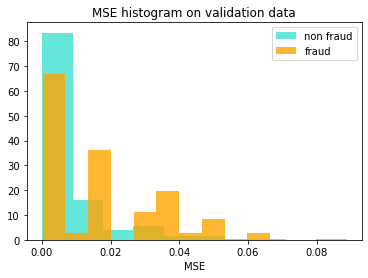

In [249]:
predict_mse_histogram_validation(model, True)

In [250]:
model.save("q6_autoencoder.h5")

2/2 [==============================] - 0s 2ms/step


<Figure size 1080x360 with 0 Axes>

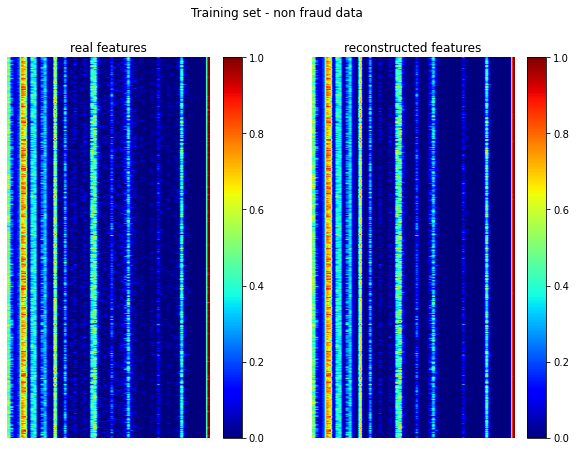

<Figure size 1080x360 with 0 Axes>

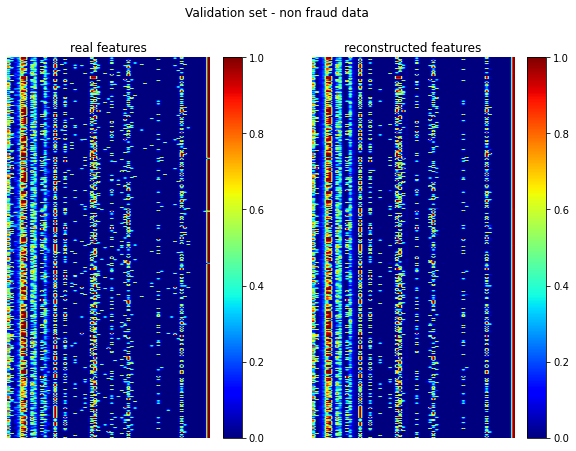

<Figure size 1080x360 with 0 Axes>

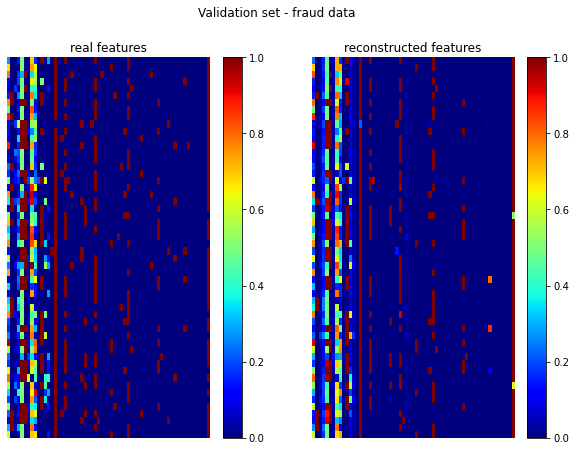

In [251]:
x_hat_tr_nf = model.predict(x_tr_nf)
# validation data that is non fraud
x_valid_non_fraud = x_valid[y_valid==0]
x_hat_valid_non_fraud = model.predict(x_valid_non_fraud)
# validation data that is fraud
x_valid_fraud = x_valid[y_valid==1]
x_hat_valid_fraud = model.predict(x_valid_fraud)


plt.figure(figsize=(15, 5))
plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Training set - non fraud data")
plt.subplot(1, 2, 1)
plt.imshow(x_tr_nf.to_numpy(), aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("real features")
plt.subplot(1, 2, 2)
plt.imshow(x_hat_tr_nf, aspect='auto', cmap="jet", interpolation=None,vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("reconstructed features")

plt.figure(figsize=(15, 5))
plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Validation set - non fraud data")
plt.subplot(1, 2, 1)
plt.imshow(x_valid_non_fraud.to_numpy(), aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("real features")
plt.subplot(1, 2, 2)
plt.imshow(x_hat_valid_non_fraud, aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("reconstructed features")
plt.show()

plt.figure(figsize=(15, 5))
plt.subplots(1,2,figsize=(10,7))
plt.suptitle("Validation set - fraud data")
plt.subplot(1, 2, 1)
plt.imshow(x_valid_fraud.to_numpy(), aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("real features")
plt.subplot(1, 2, 2)
plt.imshow(x_hat_valid_fraud, aspect='auto', cmap="jet", interpolation=None, vmin=0, vmax=1)
plt.colorbar()
plt.axis('off')
plt.title("reconstructed features")
plt.show()

19/19 [==============================] - 0s 664us/step


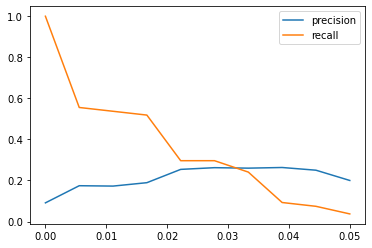

In [252]:
# draw precision recall curves for various thresholds
from sklearn.metrics import confusion_matrix, recall_score, precision_score

x_hat_valid = model.predict(x_valid)
mse_valid = np.mean((x_hat_valid - x_valid) ** 2, axis=1)

precisions = []
recalls = []
thresholds = np.linspace(0, 0.05, 10)
for t in thresholds:
    y_pred = mse_valid > t
    precisions.append(precision_score(y_valid, y_pred))
    recalls.append(recall_score(y_valid, y_pred))

plt.figure()
plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
_=plt.legend(["precision", "recall"])

0.016808797918864186


Text(0.5, 1.0, 'Confusion matrix of the predictions on the validation data')

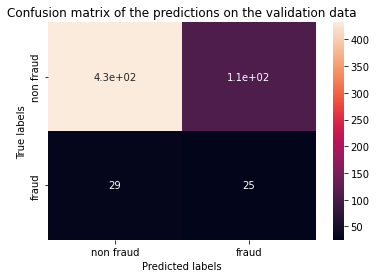

In [259]:
# We choose a threshold such that 80 percentile of the non fraud validation data
mse_valid_non_fraud = np.mean((x_valid_non_fraud - x_hat_valid_non_fraud) ** 2, axis=1)

threshold = np.percentile(mse_valid_non_fraud, 80)
print(threshold)
y_pred = mse_valid > threshold
cmat = confusion_matrix(y_valid.to_numpy(), y_pred)

plt.figure()
sns.heatmap(cmat, annot=True, xticklabels=["non fraud", "fraud"], yticklabels=["non fraud", "fraud"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix of the predictions on the validation data")

19/19 [==============================] - 0s 755us/step
Test data size: 593
Suspicious: 152
detection rate: 0.2563237774030354, hit rate: 0.17105263157894737


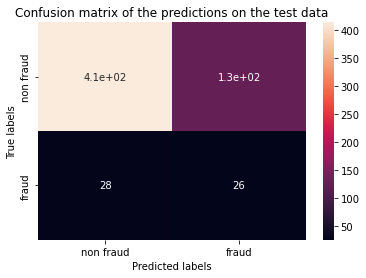

In [260]:
# prediction on test data
x_hat_test = model.predict(x_test)
mse_test = np.mean((x_test - x_hat_test)**2, axis=1)
# predict fraud/non fraud using the threshold
y_pred_test = mse_test > threshold

# confusion matrix
cmat = confusion_matrix(y_test.to_numpy(), y_pred_test)
plt.figure()
sns.heatmap(cmat, annot=True, xticklabels=["non fraud", "fraud"], yticklabels=["non fraud", "fraud"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion matrix of the predictions on the test data")

# Detection rate and hit rate on the test data
print("Test data size: {}".format(y_pred_test.shape[0]))
print("Suspicious: {}".format(sum(y_pred_test)))

detection_rate = sum(y_pred_test) / y_pred_test.shape[0]
hit_rate = sum(y_pred_test * y_test) / sum(y_pred_test)

print("detection rate: {}, hit rate: {}".format(detection_rate, hit_rate))